In [1]:
import numpy as np

from pathlib import Path
import re
from random import randint
import logging

import tkinter as tk
from tkinter import filedialog

import json
import struct

import matplotlib.pyplot as plt

In [4]:
%cd ..
%load_ext autoreload

c:\Users\kepes\Projects\segmentation


In [17]:
%autoreload 2
from src.MapData import MapData

In [6]:
debug_log = logging.Logger('default_logger',level=logging.DEBUG)

In [6]:
root = tk.Tk()
root.withdraw()

''

In [16]:
%%writefile ./src/MapData.py

import numpy as np
import re
from pathlib import Path
from tkinter import filedialog
from random import randint
import json
import struct
import matplotlib.pyplot as plt

class MapData:
  """Class for handling hyperspectral images stored in the .libsdata file format
  """
  def __init__(self):
    self.file_path = Path(
      filedialog.askopenfilename(filetypes=[('LIBS data','*.libsdata')])
    )
    self.BYTE_SIZE = 4
    self.data_type = None
    self.metadata = None


  def get_map_dimensions(self):
    """Gets the measured map's dimensions (in pixels) assuming that the filename contains this information
    """
    map_dimensions = re.findall(
        '[0-9]{3}x[0-9]{3}',
        self.file_path.name
    )[0].split('x')

    self.map_dimensions = [int(x) for x in map_dimensions]


  def get_metadata(self):
    """Load metadata from the metadata file corresponding to the selected data file
    """
    metadata_path = self.file_path.with_suffix('.libsmetadata')
    if metadata_path.is_file():
      with open(
        self.file_path.with_suffix('.libsmetadata'),'r'
      ) as file:

        self.metadata = json.load(file)
    else:
      raise ImportError('Metadata file is missing')
    

  def create_data_type(self):
    """Defines the data_type used for loading in the binary data (takes information from the metadata)
    """
    if self.metadata is None: self.get_metadata()
    self.data_type = np.dtype(
      [(
        'data', 
        np.float32, 
        self.metadata.get('wavelengths')
      )]
    )


  def load_wavelenths(self):
    """Load the wavelength vector from the binary data file
    """
    if self.data_type is None: self.create_data_type()
    self.wvl = np.fromfile(
      self.file_path,
      self.data_type,
      count=1
    )['data'][0]


  def load_batch_of_spectra(self, batch_size:int, start_ndx:int):
    """Load a batch of consecutive spectra from the binary data file

    Args:
        batch_size (int): number of spectra to load
        start_ndx (int): index of the first spectrum in the batch (in the whole data file)
    """
    if self.data_type is None: self.create_data_type()
    if batch_size + start_ndx + 1 < self.metadata.get('spectra'):
      self.batch_spectra = np.fromfile(
        self.file_path,
        self.data_type,
        count=batch_size,
        offset=(1+start_ndx) * self.metadata.get('wavelengths') * self.BYTE_SIZE #1 for skipping wavelengths
      )['data']
    else:
      print('The chosen batchsize and offset are out of bounds')


  def load_random_spectrum_from_batch(self, batch_size:int):
    """Loads a single spectrum from every batch defined by the batch_size parameter

    Args:
        batch_size (int): Number of spectra from which 1 is randomly sampled
    """
    batch_count = self.metadata.get('spectra') // batch_size
    debug_log.debug(batch_count)

    data = []
    with open(self.file_path,'rb') as source:      
      source.seek(
        self.metadata.get('wavelengths') * self.BYTE_SIZE,
        0
      )

      for _ in range(batch_count):
        ndx = randint(0,batch_size)
        debug_log.debug(f'{ndx}')
        
        source.seek(
          self.metadata.get('wavelengths') * self.BYTE_SIZE * (ndx - 1),
          1
        )
        
        for _ in range(self.metadata.get('wavelengths')):
          data.extend(
            struct.unpack(
              'f',
              source.read(self.BYTE_SIZE)
            )
          )
        
        if ndx != batch_size:
          source.seek(
            self.metadata.get('wavelengths') * self.BYTE_SIZE * (batch_size - ndx - 1),
            1
          )
          
    self.random_spectra_from_batches = np.reshape(
        data,
        (-1,self.metadata.get('wavelengths'))
    )

  
  def load_random_spectrum(self):
    """Load a random spectrum from the whole data file
    """
    if self.data_type is None: self.create_data_type()
    chosen_ndx = randint(1,self.metadata.get('spectra'))
    self.random_spectrum = np.fromfile(
      self.file_path,
      self.data_type,
      count=1,
      offset=chosen_ndx * self.metadata.get('wavelengths') * self.BYTE_SIZE
    )['data'][0]


  def plot_random_spectrum(self):
    """load and plot a random spectrum from the file
    """
    fig,ax = plt.subplots()
    if not hasattr(self,'wvl'):
      self.load_wavelenths()

    self.load_random_spectrum()

    ax.plot(
      self.wvl,
      self.random_spectrum
    )
    fig.show()

  
  def load_all_data(self):
    """loads all spectra from the file
    """
    if self.data_type is None: self.create_data_type()
    self.spectra = np.fromfile(
      self.file_path,
      self.data_type,      
      offset=self.metadata.get('wavelengths') * self.BYTE_SIZE
    )['data']

Overwriting ./src/MapData.py


In [18]:
map_data = MapData()
map_data.get_metadata()
map_data.get_map_dimensions()
map_data.load_wavelenths()

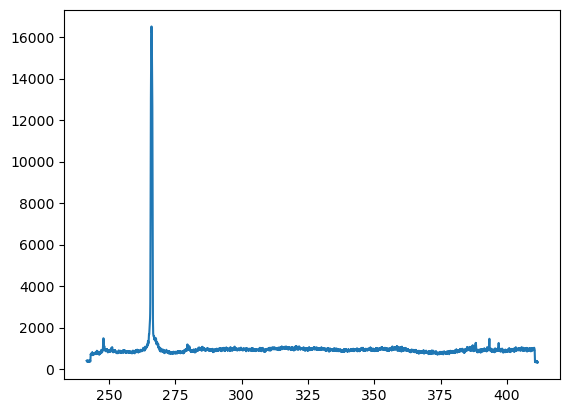

In [25]:
map_data.plot_random_spectrum()